In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from sklearn import neighbors
from sklearn.neighbors import kneighbors_graph
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import Image
import ipyplot

# Team 2 - Skin Lesion Detections
---

### Dataset Overview 

The **HAM10000** ("Human Against Machine with 10000 training images") dataset is composed of: 

- 10015 images of labelled skin lesions
- Accompanying meta-data. 

In [2]:
from IPython.display import Image, display
ims = ['{}/ISIC_0024306.jpg'.format(imagepath), 
       '{}/ISIC_0024307.jpg'.format(imagepath),
       '{}/ISIC_0024308.jpg'.format(imagepath),
       '{}/ISIC_0024309.jpg'.format(imagepath),
       '{}/ISIC_00243010.jpg'.format(imagepath),
       '{}/ISIC_00243011.jpg'.format(imagepath),
       '{}/ISIC_00243012.jpg'.format(imagepath), 
       '{}/ISIC_00243013.jpg'.format(imagepath), 
       '{}/ISIC_00243014.jpg'.format(imagepath)]

for imageName in listOfImageNames:
    image = display(Image(filename=imageName))

NameError: name 'imagepath' is not defined

**Metadata**

---

Our metadata contains information for each lesion: 

1. 'dx' - the type of skin lesion 
2. 'dx-type' - how the lesion was discovered
3. Patient gender
4. Patient age 
5. Patient sex 
6. Where the lesion was detected

--- 

In [3]:
file = '/Users/cameronsellers/code/cecyprice/skin_lesion_detection/dataset/HAM10000_metadata.csv'
meta_data = pd.read_csv(file, ',')
meta_data.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### Project Aims 

---

> **To train a model to predict the type of skin-lesion, 'dx' from an image** 



> **To create an app that can take a skin lesion image and output a prediction** 

# AGENDA

--- 

1. Data Preparation
4. Model construction 
5. Hyperparameters 
6. Results
7. Future perspectives

# DATA PREPARATION 
---

### Data retrieval 

### Data Visualisation and Cleaning 

#### Balancing 

There are seven types of skin lesion in the HAM10000 set: 

---

1.   Melanocytic nevi              - 'nv'
2.   Melanoma                      - 'mel'
3.   Benign keratosis-like lesions - 'bkl'
4.   Basal cell carcinoma          - 'bcc'
5.   Actinic keratoses             - 'akiec'
6.   Vascular lesions              - 'vasc'
7.   Dermatofibroma                - 'df'

--- 

#### Missing values and Duplicates

The dataset contains a few missing values and duplicates that can be easily filled or removed


lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64


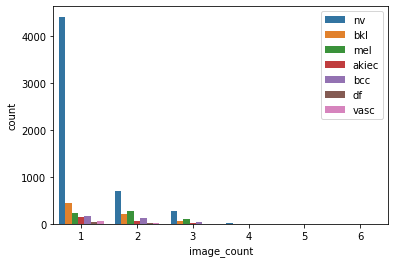

In [4]:
repetition_counts = meta_data.groupby('lesion_id').agg({'image_id': 'count', 'dx_type': 'count', 'age': 'mean', 'sex': 'count', 'localization': 'count', 'dx': 'first', }).reset_index()
repetition_counts.columns = ['lesion_id', 'image_count', 'count_dx_type', 'mean_age', 'count_sex', 'count_location', 'dx']

print(meta_data.isnull().sum())
chart = repetition_counts[['image_count', 'dx', 'lesion_id']]
chart.head()
sns.countplot(x="image_count", hue="dx", data=chart)
plt.legend(loc='upper right')

In [5]:
## fill 67 missing age values with mean 
meta_data['age'].fillna((meta_data['age'].mean()), inplace = True)

## drop duplicates as duplicates evenly distributed across lesion types 
meta_data = meta_data.drop_duplicates(subset=['lesion_id'], keep = 'first')

#### Balancing 
---

We can see representation of each lesion is **unbalanced** 

> 'nv' lesions are overrepresented 


> 'vasc' and 'df' lesions are underrepresented 

nv       5403
bkl       727
mel       614
bcc       327
akiec     228
vasc       98
df         73
Name: dx, dtype: int64

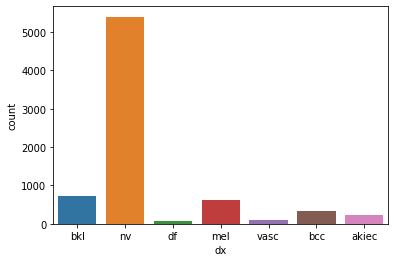

In [6]:
sns.countplot(meta_data['dx'])
meta_data['dx'].value_counts()

We need to balance by **undersampling** nv, then **augment** the whole dataset to improve 'vasc' and 'df' representation. 

In [7]:
def balance(data, under_sample_size):
        ## isolate nv rows
        data_nv = data[data['dx'] == 'nv']
        # define scaling parameters 
        sample_size = under_sample_size
        scaling = under_sample_size / data_nv.shape[0] 
        # stratified sampling 
        rus = RandomUnderSampler(sampling_strategy={'lower extremity' : int(1224*scaling),
                                                    'trunk' : int(1153*scaling), 
                                                    'back' : int(1058*scaling),
                                                    'abdomen' : int(719*scaling), 
                                                    'upper extremity' : int(504*scaling) ,
                                                    'foot' : int(209*scaling), 
                                                    'unknown' : int(175*scaling),
                                                    'chest' : int(112*scaling),
                                                    'face' : int(61*scaling),
                                                    'neck' : int(60*scaling), 
                                                    'genital' : int(43*scaling), 
                                                    'hand' : int(39*scaling), 
                                                    'scalp' : int(24*scaling), 
                                                    'ear' : int(19*scaling),
                                                    'acral' : int(3*scaling)+1
                                                   }, 
                                   random_state=None,
                                   replacement=False,
                                )
        ## fit strtaified sampling model 
        n_x, n_y = rus.fit_resample(data_nv, data_nv['localization'])
        ## delete nv rows from original dataset
        no_nv_data = data[data.dx != 'nv']
        data = pd.concat([n_x, no_nv_data], axis=0)
        return data
    
meta_data = balance(meta_data, 1000)

In [8]:
def data_augmentation(df, image_size = 'resized'):
    print(df.shape)
    df = df.reset_index(drop=True)
    ## Define random image modifications
    aug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

    if image_size == 'resized':
        target_images = 'images_resized'
        input_size = (75,100,3)
        df = df.drop(['images'], axis =1)
        new_df = df.copy()
        new_df = new_df.drop(['images_resized'], axis=1)

    elif image_size == 'full_size':
        target_images = 'images'
        input_size = (450,600,3)
        df = df.drop(['images_resized'], axis =1)
        new_df = df.copy()
        new_df = new_df.drop(['images'], axis=1)

    ## Create np.array of augmented images from original images dataframe. Reshape to feed into dataGen
    images_array = np.array([i.reshape(input_size) for i in df[target_images].values])
    #construct the actual Python generator, iterate over imagegenerator object
    dataGen = aug.flow(images_array, batch_size = images_array.shape[0])
    for i in dataGen:
        break
    ## flatten i before concatenating it into new dataframe copy
    i = i.reshape(len(df), input_size[0]*input_size[1]*input_size[2])
    ## turn i from array into list so it can be converted into pd
    im_list = []
    for im in i:
        im_list.append(im)
    # convert i into the pandas i_df
    i_df = pd.DataFrame({target_images: im_list})
    ## concatenate new_df numpy array and new augmented image array
    com_new_df = pd.concat((new_df, i_df), axis = 1)
    ## vertically concatenate new dataframes
    frames = [df, com_new_df]
    df = pd.concat(frames)
    df.reset_index(drop=True, inplace=True)
    print(df.shape)
    return df

In [10]:
meta_data_copy = meta_data.copy()
frames = [meta_data_copy, meta_data]
meta_data = pd.concat(frames)

Samples are now:

- **more balanced** 

- **better represented**

nv       1988
bkl      1454
mel      1228
bcc       654
akiec     456
vasc      196
df        146
Name: dx, dtype: int64

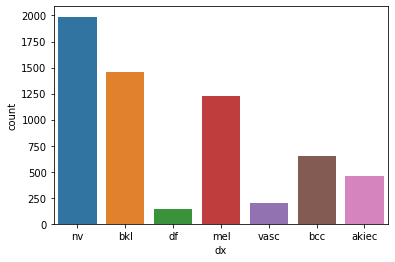

In [11]:
sns.countplot(meta_data['dx'])
meta_data['dx'].value_counts()

# MODEL CONSTRUCTION
--- 

### Baseline

### Vgg16 

### Resnet 

### DenseNet 

# HYPERPARAMETERS
---

# RESULTS
---


# FUTURE WORK
---

## to look at presentation 

**in terminal**
 - cd to notebooks in skin_lesion_detection
 - type "jupyter nbconvert Presentation.ipynb --to slides --post serve" 